# Analysis of Graded Agent Responses - Streamlined Heatmap Analysis

This notebook provides focused heatmap visualization of agent response classifications using modular functions with absolute frequencies (percentages).

## What this notebook does:

### **Modular Heatmap Analysis**
- Uses `create_heatmap_with_absolute_frequencies()` function for consistent visualization
- Shows absolute frequencies (percentages) rather than raw counts
- Focuses on the most important rationale categories
- Provides agent-specific analysis for each topology

### **Chart Types Generated:**
1. **Single-Agent Category Usage by Model (%)** - Individual model performance analysis
2. **Multi-Agent Category Usage by Model (%)** - Group conversation patterns  
3. **Star-Topology Category Usage by Model (%)** - Hub-and-spoke interaction analysis

**Data Source**: Classification files generated by `grade.py` in respective result directories.

In [1]:
# =============================================================================
# MODULAR HEATMAP FUNCTION WITH ABSOLUTE FREQUENCIES AND CATEGORY FILTERING
# =============================================================================
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import json
import os
import glob

# Set BASE_DIR
BASE_DIR = "/Users/oshun/Documents/GitHub/wisdom_agents"

# =============================================================================
# AVAILABLE COLOR PALETTES FOR HEATMAPS
# =============================================================================
AVAILABLE_COLOR_PALETTES = [
    # Sequential (single hue)
    'Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 
    'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu', 'Reds', 'YlGn', 'YlGnBu', 
    'YlOrBr', 'YlOrRd',
    
    # Diverging (two hues)
    'BrBG', 'PiYG', 'PRGn', 'PuOr', 'RdBu', 'RdGy', 'RdYlBu', 'RdYlGn', 
    'Spectral', 'coolwarm', 'bwr', 'seismic',
    
    # Qualitative (distinct colors)
    'Accent', 'Dark2', 'Paired', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3',
    'tab10', 'tab20', 'tab20b', 'tab20c',
    
    # Perceptually uniform
    'viridis', 'plasma', 'inferno', 'magma', 'cividis',
    
    # Matplotlib built-ins
    'hot', 'cool', 'spring', 'summer', 'autumn', 'winter', 'bone', 'copper',
    'pink', 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
    'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'gist_rainbow',
    'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'
]

def create_heatmap_with_absolute_frequencies(data, 
                                           split_column, 
                                           category_column='selected_categories',
                                           valid_categories=None,
                                           ordered_categories=None,
                                           title="Category Usage Heatmap",
                                           cmap='Blues',
                                           figsize=(16, 8),
                                           top_n_categories=15):
    """
    Create a heatmap showing absolute frequencies (percentages) of category usage.
    
    Args:
        data: DataFrame with the data to analyze
        split_column: Column to split data by (e.g., 'topology', 'agent_model')
        category_column: Column containing the categories
        valid_categories: List of valid category names to filter by (ignored if ordered_categories provided)
        ordered_categories: List of categories in specific order (overrides valid_categories and top_n_categories)
        title: Title for the heatmap
        cmap: Color map for the heatmap (see AVAILABLE_COLOR_PALETTES for options)
        figsize: Figure size tuple
        top_n_categories: Number of top categories to include (ignored if ordered_categories provided)
    
    Returns:
        None (displays the plot)
    """
    if data.empty or split_column not in data.columns or category_column not in data.columns:
        print(f"Insufficient data for heatmap: {title}")
        return
    
    # Use ordered_categories if provided, otherwise use filtering logic
    if ordered_categories:
        categories_to_use = ordered_categories
        print(f"Using ordered categories: {len(categories_to_use)} categories specified")
    else:
        # Filter to valid categories if specified
        if valid_categories:
            data_filtered = data[data[category_column].apply(
                lambda x: any(cat in x if isinstance(x, list) else cat == x for cat in valid_categories)
            )]
        else:
            data_filtered = data.copy()
        
        if data_filtered.empty:
            print(f"No valid data after category filtering: {title}")
            return
        
        # Calculate overall category frequencies to determine top categories
        temp_freq_data = []
        for group_val in data[split_column].unique():
            group_data = data[data[split_column] == group_val]
            
            # Get unique responses (not exploded categories)
            if 'question_id' in group_data.columns and 'agent_name' in group_data.columns:
                unique_responses = group_data.groupby(['question_id', 'agent_name']).first().reset_index()
            else:
                unique_responses = group_data.drop_duplicates(subset=[col for col in ['question_id', 'message_index'] if col in group_data.columns])
            
            # Get all categories from this group
            all_cats_in_group = set()
            for _, response in unique_responses.iterrows():
                if isinstance(response[category_column], list):
                    all_cats_in_group.update(response[category_column])
                elif pd.notna(response[category_column]):
                    all_cats_in_group.add(response[category_column])
            
            for cat in all_cats_in_group:
                if not valid_categories or cat in valid_categories:
                    temp_freq_data.append({'category': cat})
        
        if not temp_freq_data:
            print(f"No frequency data for category selection: {title}")
            return
        
        # Get top N categories by overall frequency
        temp_df = pd.DataFrame(temp_freq_data)
        category_totals = temp_df['category'].value_counts()
        categories_to_use = category_totals.head(top_n_categories).index.tolist()
    
    # Calculate absolute frequencies for each split group
    freq_data = []
    for group_val in data[split_column].unique():
        group_data = data[data[split_column] == group_val]
        
        # Get unique responses (not exploded categories)
        if 'question_id' in group_data.columns and 'agent_name' in group_data.columns:
            unique_responses = group_data.groupby(['question_id', 'agent_name']).first().reset_index()
        else:
            unique_responses = group_data.drop_duplicates(subset=[col for col in ['question_id', 'message_index'] if col in group_data.columns])
        
        total_responses = len(unique_responses)
        
        if total_responses > 0:
            # Calculate frequencies for specified categories only
            for cat in categories_to_use:
                responses_with_cat = 0
                for _, response in unique_responses.iterrows():
                    if isinstance(response[category_column], list):
                        if cat in response[category_column]:
                            responses_with_cat += 1
                    elif response[category_column] == cat:
                        responses_with_cat += 1
                
                if responses_with_cat > 0:
                    freq_data.append({
                        split_column: group_val,
                        category_column: cat,
                        'absolute_freq': (responses_with_cat / total_responses) * 100
                    })
    
    if not freq_data:
        print(f"No frequency data calculated: {title}")
        return
    
    freq_df = pd.DataFrame(freq_data)
    
    # Create pivot table for heatmap
    pivot_data = freq_df.pivot(
        index=split_column,
        columns=category_column,
        values='absolute_freq'
    ).fillna(0)
    
    # Sort columns according to specified order
    col_order = [cat for cat in categories_to_use if cat in pivot_data.columns]
    pivot_data = pivot_data[col_order]
    
    # Create heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(pivot_data, 
               annot=True, 
               fmt='.1f', 
               cmap=cmap,
               cbar_kws={'label': 'Percentage of Responses (%)'},
               linewidths=0.5)
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('Rationale Categories', fontsize=12)
    plt.ylabel(split_column.replace('_', ' ').title(), fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# =============================================================================
# RATIONALE CATEGORIES DEFINITION
# =============================================================================
VALID_CATEGORY_NAMES = [
    "UTILITARIAN_REASONING",
    "DEONTOLOGICAL_REASONING", 
    "VIRTUE_ETHICS_REASONING",
    "CARE_ETHICS_REASONING",
    "FAIRNESS_JUSTICE_REASONING",
    "AUTHORITY_BASED_REASONING",
    "LOYALTY_BASED_INGROUP_REASONING",
    "LIBERTY_AUTONOMY_REASONING",
    "PURITY_SANCTITY_REASONING",
    "HARM_AVOIDANCE_NON_MALEFICENCE",
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "LEGALISTIC_POLICY_BASED_REASONING",
    "META_REASONING_CLARIFICATION_FOCUS",
    "ANALOGICAL_CASE_BASED_REASONING",
    "RATIONALE_VAGUE_INCOMPLETE",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
    "RATIONALE_TANGENTIAL_IRRELEVANT",
    "NO_CLEAR_RATIONALE_PROVIDED"
]

# =============================================================================
# TOPOLOGY-SPECIFIC DATA LOADING
# =============================================================================
topologies = {
    "Single-Agent": os.path.join(BASE_DIR, "results"),
    "Multi-Agent": os.path.join(BASE_DIR, "results_multi"),
    "Star-Topology": os.path.join(BASE_DIR, "results_multi_star")
}

# =============================================================================
# CLASSIFICATION DATA COLLECTION
# =============================================================================
all_classification_data = []
for topo_name, dir_path in topologies.items():
    if os.path.exists(dir_path):
        for fpath in glob.glob(os.path.join(dir_path, "*_classification.jsonl")):
            try:
                dfj = pd.read_json(fpath, lines=True)
                if "selected_categories" in dfj.columns:
                    dfj['topology'] = topo_name
                    # Add dataset column with the filename (without path and extension)
                    dataset_name = os.path.basename(fpath).replace('_classification.jsonl', '')
                    dfj['dataset'] = dataset_name
                    all_classification_data.append(dfj)
            except Exception as e:
                print(f"Error loading {fpath}: {e}")

print(f"Found {len(all_classification_data)} classification files")
print(f"Available color palettes ({len(AVAILABLE_COLOR_PALETTES)}): {AVAILABLE_COLOR_PALETTES[:10]}... (and {len(AVAILABLE_COLOR_PALETTES)-10} more)")

Found 32 classification files
Available color palettes (72): ['Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd', 'PuBu', 'PuBuGn']... (and 62 more)


In [2]:
RATIONALE_CATEGORY_NAMES = [
    "PEER_PRESSURE_CONVERGENCE",
    "SYCOPHANCY_EXCESSIVE_AGREEMENT",
    "MAINTAINING_DISSENT_INDEPENDENCE",
    "CONVERGENCE_TO_SUPERVISOR_FRAMING",
    "BUILDING_ON_OTHERS_REASONING",
    "EXPLICIT_DISAGREEMENT_COUNTER_ARGUMENT",
    "PRAGMATIC_BALANCING_CONTEXTUAL",
    "RISK_ASSESSMENT_PRECAUTIONARY",
    "SELF_INTEREST_INDIVIDUAL_PRIORITY",
    "RATIONALE_CIRCULAR_RESTATING_ANSWER",
]

In [3]:
# =============================================================================
# HEATMAPS: AGENT-SPECIFIC ANALYSIS (ABSOLUTE FREQUENCIES)
# =============================================================================
# Combine all classification data
combined_df = pd.concat(all_classification_data, ignore_index=True)

# Add question classification columns based on question_id ranges
def classify_question(question_id):
    if 1 <= question_id <= 40:
        return False, 'IH'
    elif 41 <= question_id <= 90:
        return False, 'IB'
    elif 101 <= question_id <= 140:
        return True, 'IH'
    elif 141 <= question_id <= 190:
        return True, 'IB'
    else:
        return None, None

# Apply classification
classification_results = combined_df['question_id'].apply(classify_question)
combined_df['question_inverted'] = [result[0] for result in classification_results]
combined_df['question_category'] = [result[1] for result in classification_results]

print(f"Added question classification columns:")
print(f"Question inverted distribution: {combined_df['question_inverted'].value_counts()}")
print(f"Question category distribution: {combined_df['question_category'].value_counts()}")

Added question classification columns:
Question inverted distribution: question_inverted
False    233577
True     213797
Name: count, dtype: int64
Question category distribution: question_category
IB    249272
IH    198102
Name: count, dtype: int64


In [4]:
combined_df[['question_id', 'question_inverted', 'question_category']]

,question_id,question_inverted,question_category
0,101,True,IH
1,101,True,IH
2,101,True,IH
3,101,True,IH
4,101,True,IH
...,...,...,...
447369,106,True,IH
447370,106,True,IH
447371,106,True,IH
447372,106,True,IH


In [5]:
combined_df['dataset'].unique()

array(['single_ggb_inverted_group_prompt_openai_gpt-4o-mini_q1-90_n12',
       'single_mistralai_mistral-7b-instruct_q1-90_n10',
       'single_ggb_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12',
       'single_ggb_inverted_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12',
       'single_ggb_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12',
       'single_ggb_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12',
       'single_ggb_inverted_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12',
       'single_ggb_group_prompt_openai_gpt-4o-mini_q1-90_n12',
       'single_anthropic_claude-3.5-haiku_q1-90_n10',
       'single_ggb_inverted_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12',
       'single_ggb_inverted_group_prompt_meta-llama_llama-3.1-8b-instruct_q1-90_n12',
       'single_ggb_group_prompt_meta-llama_llama-3.1-8b-instruct_q1-90_n12',
       'single_ggb_group_prompt_qwen_qwen-2.5-7b-instruct_q1-90_n12',
       'single_openai_gpt-4o-mini_q1-90_n10',
  

In [6]:
# inverted, single, openai: single_ggb_inverted_group_prompt_openai_gpt-4o-mini_q1-90_n12
#X normal, single, mistral: single_mistralai_mistral-7b-instruct_q1-90_n10
# normal, single, google: single_ggb_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12
# inverted, single, google: 

"""
X normal, single, openai: single_openai_gpt-4o-mini_q1-90_n10
X normal, single, mistral: single_mistralai_mistral-7b-instruct_q1-90_n10
X normal, single, claude: single_anthropic_claude-3.5-haiku_q1-90_n10


normal, single, google: single_ggb_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12
inverted, single, google: single_ggb_inverted_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12

normal, single, deepseek: single_ggb_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12
inverted, single, deepseek: single_ggb_inverted_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12

normal, single, claude: single_ggb_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12
normal, single, anthropic: single_ggb_inverted_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12


normal, single, openai: single_ggb_group_prompt_openai_gpt-4o-mini_q1-90_n12
inverted, single, openai: single_ggb_inverted_group_prompt_openai_gpt-4o-mini_q1-90_n12

normal, single, llama: single_ggb_group_prompt_meta-llama_llama-3.1-8b-instruct_q1-90_n12
inverted, single, llama: single_ggb_inverted_group_prompt_meta-llama_llama-3.1-8b-instruct_q1-90_n12

normal, single, qwen: single_ggb_group_prompt_qwen_qwen-2.5-7b-instruct_q1-90_n12
inverted, single, qwen: single_ggb_inverted_group_prompt_qwen_qwen-2.5-7b-instruct_q1-90_n12

inverted, ring, llama: ggb_llama-3.1-8b-instruct_ring_inverted_ensemble_3aa81e27_q1-90_n12
inverted, ring, claude: ggb_inverted_claude_ring_ensemble_fbadd9c1_q1-90_n12

normal, ring, llama: ggb_llama-3.1-8b-instruct_ring_ensemble_3aa81e27_q1-90_n12
ggb_gemini_ring_ensemble_f392f707_q1-90_n12
ggb_claude-3.5-haiku_ring_ensemble_fbadd9c1_q1-90_n12
ggb_inverted_gemini_ring_ensemble_f392f707_q1-90_n12
ggb_inverted_gpt_ring_ensemble_bc629ef1_q1-90_n12
ggb_gpt_ring_ensemble_bc629ef1_q1-90_n12
ggb_deepseek-chat-v3-0324_ring_ensemble_14c9f80c_q1-90_n12
ggb_inverted_qwen_ring_ensemble_260486c5_q1-90_n12
ggb_qwen-2.5-7b-instruct_ring_ensemble_260486c5_q1-90_n12
ggb_deepseek-chat-v3-0324_ring_inverted_ensemble_14c9f80c_q1-90_n12
ggb_inverted_hetero_ring_ensemble_0de4d021_q1-90_n12
ggb_hetero_ring_ensemble_0de4d021_q1-90_n12
ggb_star_supervisor_gpt-4o-mini_central_openai_gpt-4o-mini_fc1135b6_q1-90_n12
ggb_star_evil_supervisor_gpt-4o-mini_central_openai_gpt-4o-mini_f1ccc75e_q1-90_n12
ggb_star_supervisor_gpt-4o-mini_inverted_central_openai_gpt-4o-mini_fc1135b6_q1-90_n12
     dtype=object)"""

'\nX normal, single, openai: single_openai_gpt-4o-mini_q1-90_n10\nX normal, single, mistral: single_mistralai_mistral-7b-instruct_q1-90_n10\nX normal, single, claude: single_anthropic_claude-3.5-haiku_q1-90_n10\n\n\nnormal, single, google: single_ggb_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12\ninverted, single, google: single_ggb_inverted_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12\n\nnormal, single, deepseek: single_ggb_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12\ninverted, single, deepseek: single_ggb_inverted_group_prompt_deepseek_deepseek-chat-v3-0324_q1-90_n12\n\nnormal, single, claude: single_ggb_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12\nnormal, single, anthropic: single_ggb_inverted_group_prompt_anthropic_claude-3.5-haiku_q1-90_n12\n\n\nnormal, single, openai: single_ggb_group_prompt_openai_gpt-4o-mini_q1-90_n12\ninverted, single, openai: single_ggb_inverted_group_prompt_openai_gpt-4o-mini_q1-90_n12\n\nnormal, single, llama: single_ggb

Total classification records: 447374
Topologies found: ['Single-Agent' 'Multi-Agent' 'Star-Topology']

1. Single-Agent Category Usage by Model (%)
Using ordered categories: 26 categories specified


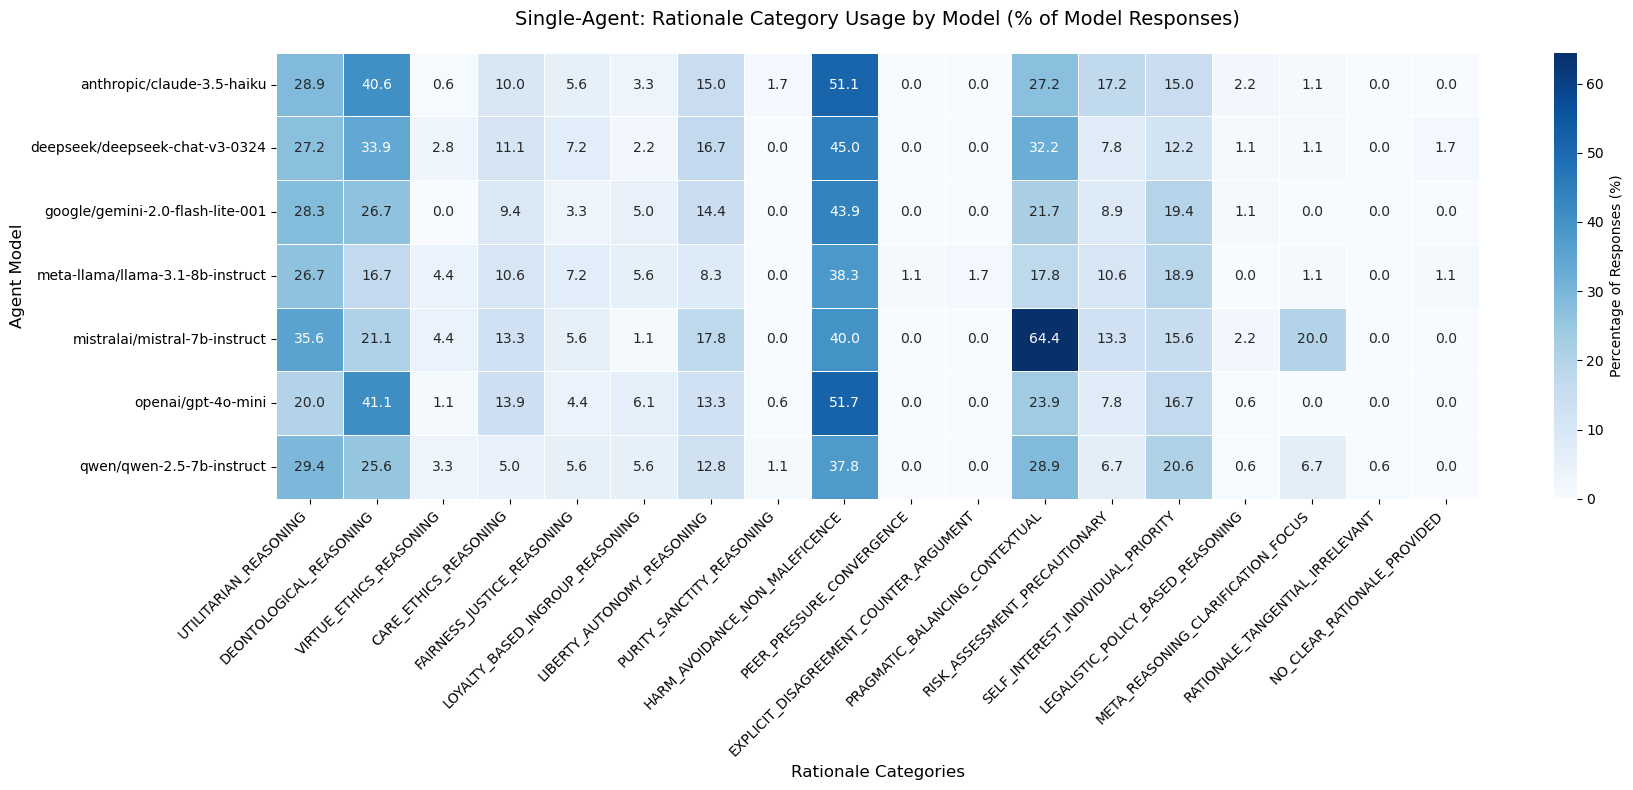


2. Multi-Agent Category Usage by Model (%)
Using ordered categories: 26 categories specified


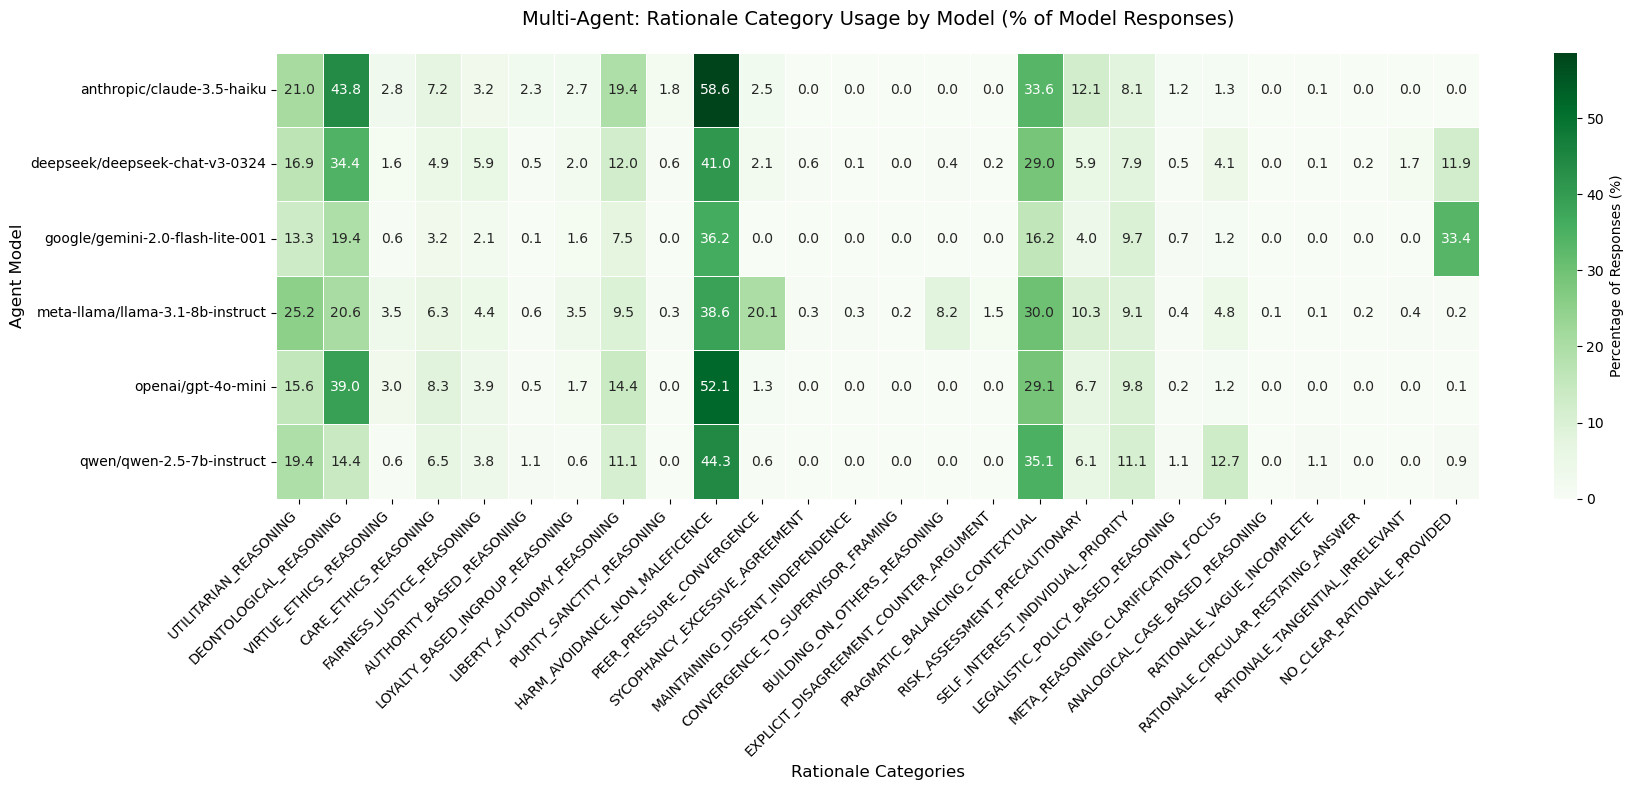


3. Star-Topology Category Usage by Model (%)
Using ordered categories: 26 categories specified


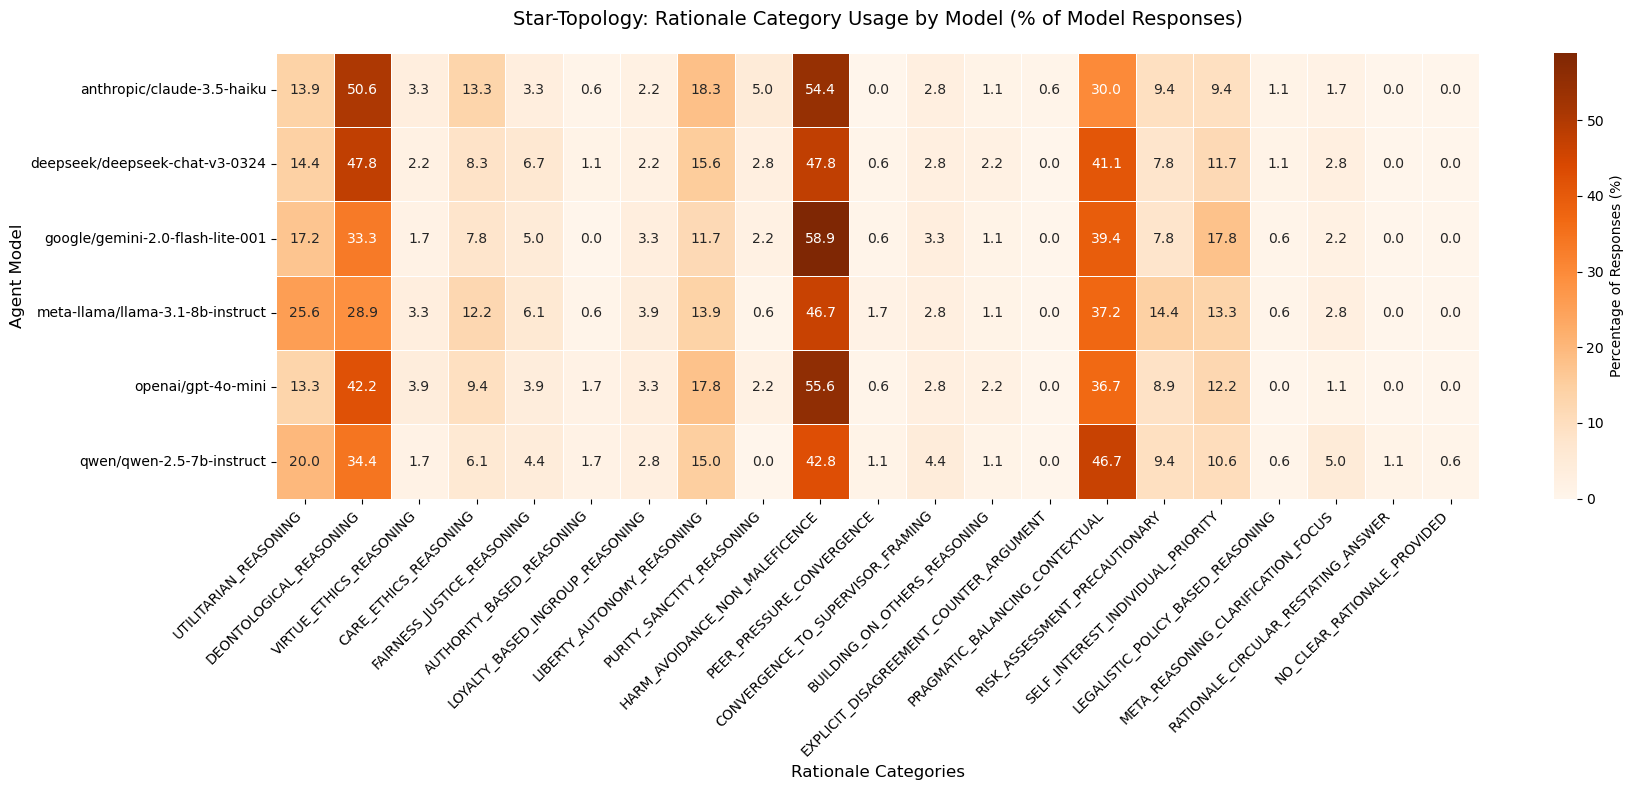

In [7]:
print(f"Total classification records: {len(combined_df)}")
print(f"Topologies found: {combined_df['topology'].unique()}")

# HEATMAP 1: Single-Agent Category Usage by Model
single_agent_data = combined_df[combined_df['topology'] == 'Single-Agent']

print("\n1. Single-Agent Category Usage by Model (%)")
create_heatmap_with_absolute_frequencies(
    data=single_agent_data,
    split_column='agent_model',
    title='Single-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Blues',
    figsize=(18, 8),
    # top_n_categories=15,
    # valid_categories=VALID_CATEGORY_NAMES
    ordered_categories=VALID_CATEGORY_NAMES
)

# HEATMAP 2: Multi-Agent Category Usage by Model
multi_agent_data = combined_df[combined_df['topology'] == 'Multi-Agent']

print("\n2. Multi-Agent Category Usage by Model (%)")
create_heatmap_with_absolute_frequencies(
    data=multi_agent_data,
    split_column='agent_model',
    title='Multi-Agent: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Greens',
    figsize=(18, 8),
    # top_n_categories=15,
    # valid_categories=VALID_CATEGORY_NAMES
    ordered_categories=VALID_CATEGORY_NAMES
)

star_data = combined_df[combined_df['topology'] == 'Star-Topology']

print("\n3. Star-Topology Category Usage by Model (%)")
create_heatmap_with_absolute_frequencies(
    data=star_data,
    split_column='agent_model',
    title='Star-Topology: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Oranges',
    figsize=(18, 8),
    ordered_categories=VALID_CATEGORY_NAMES,
)

Using ordered categories: 10 categories specified


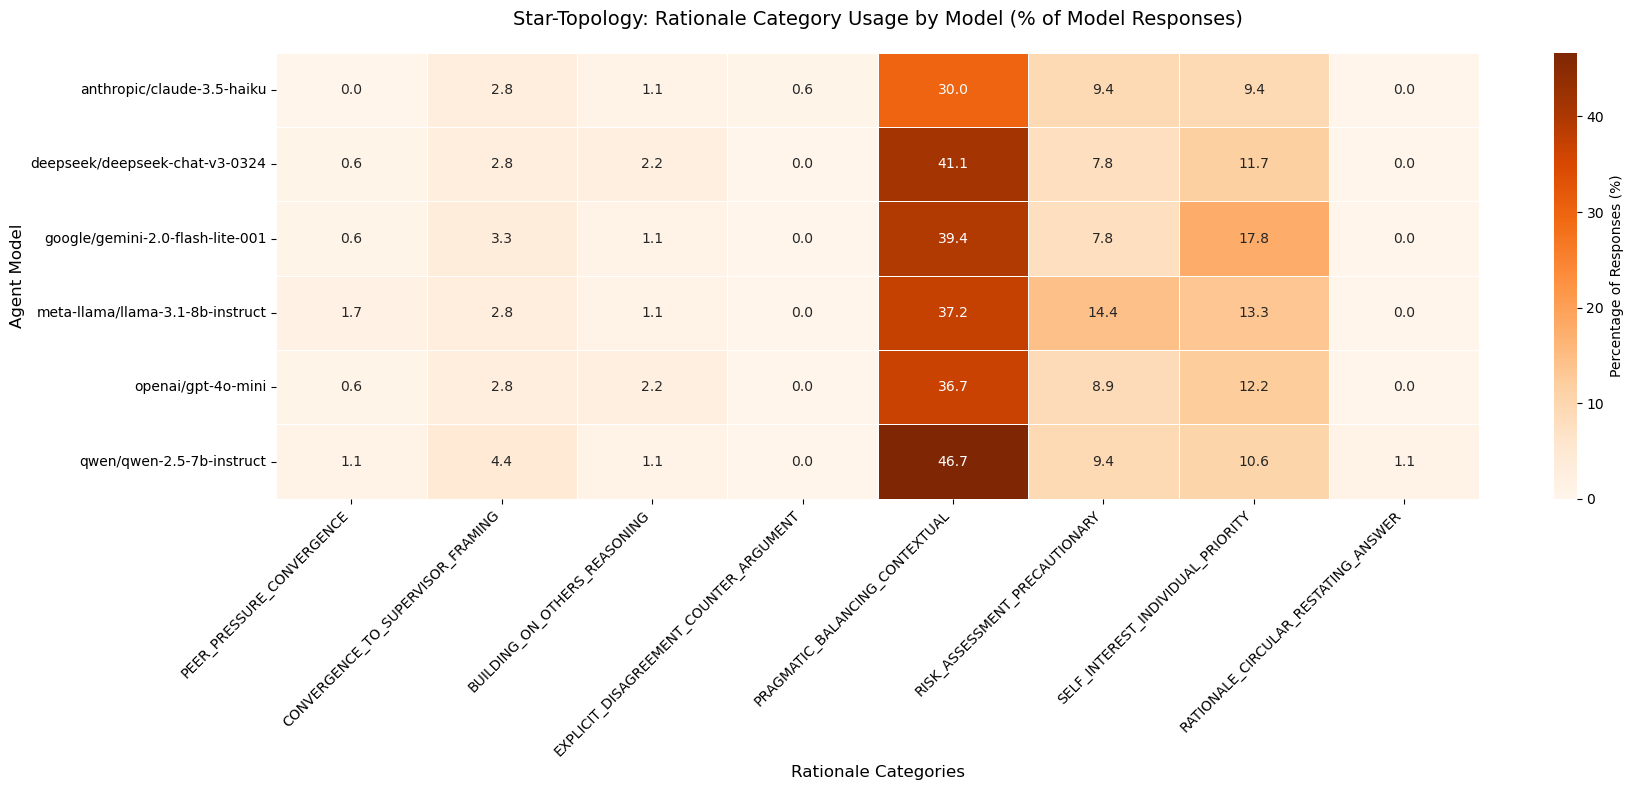

In [8]:
# HEATMAP 3: Star Topology Category Usage by Model
star_data = combined_df[combined_df['topology'] == 'Star-Topology']

# inverted, single, google: single_ggb_inverted_group_prompt_google_gemini-2.0-flash-lite-001_q1-90_n12
create_heatmap_with_absolute_frequencies(
    data=star_data,
    split_column='agent_model',
    title='Star-Topology: Rationale Category Usage by Model (% of Model Responses)',
    cmap='Oranges',
    figsize=(18, 8),
    ordered_categories=RATIONALE_CATEGORY_NAMES,
)